In [2]:
import json
import os
import numpy as np

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20, 'text.usetex': True})

import pandas as pd
import torch
from tqdm import tqdm

import pickle
import glob

from flighted import common_utils, pretrained
from flighted.common_utils import PROTEIN_ALPHABET_EXTENDED
# from flighted.flighted_inference import flighted_models

from Bio import SeqIO
import copy

from Levenshtein import distance

In [ ]:
model_folder = '../Data/DHARMA_Models/'

def load_model():
    _, model = pretrained.load_trained_flighted_model("DHARMA", cpu_only=True)
    return model

model = load_model()

In [ ]:
data_folder = '../Data/TEV_Landscape'


for i, filepath in enumerate(glob.glob(os.path.join(data_folder, '*.pkl'))):
    data_dict = pickle.load(open(filepath, 'rb'))
    seqs = []
    pred_means = []
    pred_variances = []
    num_reads = []
    for seq in tqdm(data_dict.keys()):
        seqs += [seq]
        num_reads += [len(data_dict[seq])]
        
        char_array = [list(val) for val in data_dict[seq]]
        int_array = [[int(val) for val in list] for list in char_array]
        mean, variance = model.infer_fitness_from_dharma(torch.nn.functional.one_hot(torch.LongTensor(int_array), num_classes=3))
        del char_array
        del int_array
        pred_means += [mean.detach().numpy()[()]]
        pred_variances += [variance.detach().numpy()[()]]
    del data_dict
    np.save(os.path.join(data_folder, f'seqs_{i}.npy'), seqs)
    np.save(os.path.join(data_folder, f'pred_means_{i}.npy'), pred_means)
    np.save(os.path.join(data_folder, f'pred_variances_{i}.npy'), pred_variances)
    np.save(os.path.join(data_folder, f'num_reads_{i}.npy'), num_reads)

In [ ]:
seqs = []
num_reads = []
pred_means = []
pred_variances = []
for i in range(16):
    seqs += list(np.load(os.path.join(data_folder, f'seqs_{i}.npy')))
    num_reads += list(np.load(os.path.join(data_folder, f'num_reads_{i}.npy')))
    pred_means += list(np.load(os.path.join(data_folder, f'pred_means_{i}.npy')))
    pred_variances += list(np.load(os.path.join(data_folder, f'pred_variances_{i}.npy')))

In [ ]:
data_dict = {'Sequences': seqs, 'Number of Reads': num_reads, 'Fitness Mean': pred_means, 'Fitness Variance': pred_variances}
data_df = pd.DataFrame(data_dict)
data_df.to_csv(os.path.join(data_folder, 'flighted_fitnesses.csv'), index=False)

In [5]:
data_folder = '../Data/TEV_Landscape'
data_df = pd.read_csv(os.path.join(data_folder, 'flighted_fitnesses.csv'))
pred_means = data_df['Fitness Mean'].values
pred_variances = data_df['Fitness Variance'].values
num_reads = data_df['Number of Reads'].values

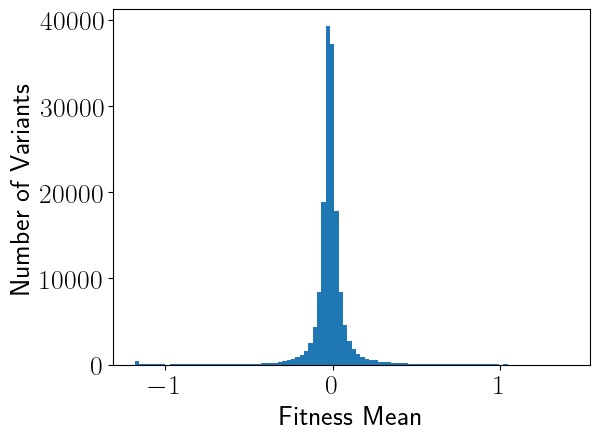

In [6]:
fig, ax = plt.subplots()
ax.hist(pred_means, bins=100)
ax.set_xlabel('Fitness Mean')
ax.set_ylabel('Number of Variants')
fig.tight_layout()

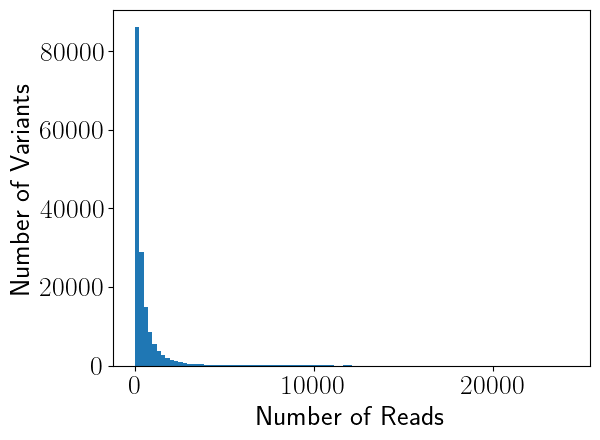

In [7]:
fig, ax = plt.subplots()
ax.hist(num_reads, bins=100)
ax.set_xlabel('Number of Reads')
ax.set_ylabel('Number of Variants')
fig.tight_layout()

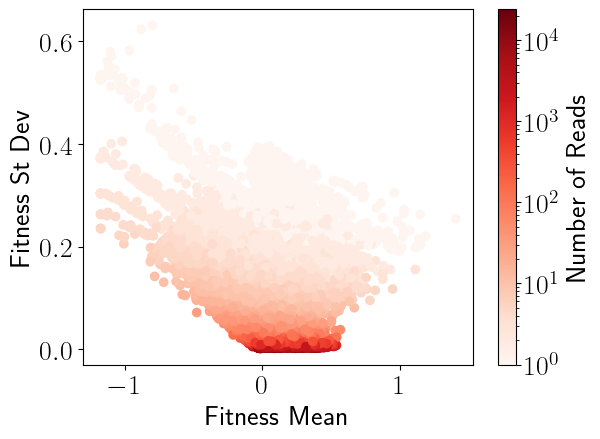

In [8]:
fig, ax = plt.subplots()
sc = ax.scatter(pred_means, np.sqrt(pred_variances), c=num_reads, cmap='Reds', norm=mpl.colors.LogNorm())
fig.colorbar(sc, label='Number of Reads', ax=ax)
ax.set_xlabel('Fitness Mean')
ax.set_ylabel('Fitness St Dev')
fig.tight_layout()

In [ ]:
with open(os.path.join(data_folder, "TEV_wt_sequence.fasta")) as f:
    wt_record = SeqIO.read(f, format="fasta")

with open(os.path.join(data_folder, "TEV_mutated_sequence.fasta")) as f:
    mutated_record = SeqIO.read(f, format="fasta")

mutated_resnums = []
for i, (chara, charb) in enumerate(zip(str(wt_record.seq), str(mutated_record.seq))):
    if chara != charb and charb == 'X':
        mutated_resnums += [i]

In [ ]:
def generate_complete_sequence(subsequence):
    complete_seq = list(copy.copy(str(wt_record.seq)))
    for i, resnum in enumerate(mutated_resnums):
        complete_seq[resnum] = subsequence[i]
    return ''.join(complete_seq)

data_df['Complete Sequence'] = data_df.apply(lambda x: generate_complete_sequence(x['Sequences']), axis=1)

In [ ]:
data_df['Mutation Distance'] = [distance(str(wt_record.seq), string) for string in data_df['Complete Sequence'].values]

In [ ]:
data_df.to_csv(os.path.join(data_folder, 'flighted_fitnesses.csv'), index=False)

In [ ]:
# data_df = data_df.set_index('Complete Sequence')
one_vs_rest_trainval = data_df[data_df['Mutation Distance'] <= 1]
one_vs_rest_test = data_df[data_df['Mutation Distance'] > 1]
one_vs_rest_val = one_vs_rest_trainval.sample(frac=0.1)
one_vs_rest_train = one_vs_rest_trainval.drop(one_vs_rest_val.index.values, axis=0)

one_vs_rest_train.to_csv(os.path.join(data_folder, 'Splits', 'one_vs_rest_train.csv'))
one_vs_rest_val.to_csv(os.path.join(data_folder, 'Splits', 'one_vs_rest_val.csv'))
one_vs_rest_test.to_csv(os.path.join(data_folder, 'Splits', 'one_vs_rest_test.csv'))

In [ ]:
two_vs_rest_trainval = data_df[data_df['Mutation Distance'] <= 2]
two_vs_rest_test = data_df[data_df['Mutation Distance'] > 2]
two_vs_rest_val = two_vs_rest_trainval.sample(frac=0.1)
two_vs_rest_train = two_vs_rest_trainval.drop(two_vs_rest_val.index.values, axis=0)

two_vs_rest_train.to_csv(os.path.ejoin(data_folder, 'Splits', 'two_vs_rest_train.csv'))
two_vs_rest_val.to_csv(os.path.join(data_folder, 'Splits', 'two_vs_rest_val.csv'))
two_vs_rest_test.to_csv(os.path.join(data_folder, 'Splits', 'two_vs_rest_test.csv'))

In [ ]:
three_vs_rest_trainval = data_df[data_df['Mutation Distance'] <= 3]
three_vs_rest_test = data_df[data_df['Mutation Distance'] > 3]
three_vs_rest_val = three_vs_rest_trainval.sample(frac=0.1)
three_vs_rest_train = three_vs_rest_trainval.drop(three_vs_rest_val.index.values, axis=0)

three_vs_rest_train.to_csv(os.path.join(data_folder, 'Splits', 'three_vs_rest_train.csv'))
three_vs_rest_val.to_csv(os.path.join(data_folder, 'Splits', 'three_vs_rest_val.csv'))
three_vs_rest_test.to_csv(os.path.join(data_folder, 'Splits', 'three_vs_rest_test.csv'))

In [9]:
one_vs_rest_train = pd.read_csv(os.path.join(data_folder, 'Splits', 'one_vs_rest_train.csv'))
one_vs_rest_test = pd.read_csv(os.path.join(data_folder, 'Splits', 'one_vs_rest_test.csv'))
two_vs_rest_train = pd.read_csv(os.path.join(data_folder, 'Splits', 'two_vs_rest_train.csv'))
two_vs_rest_test = pd.read_csv(os.path.join(data_folder, 'Splits', 'two_vs_rest_test.csv'))
three_vs_rest_train = pd.read_csv(os.path.join(data_folder, 'Splits', 'three_vs_rest_train.csv'))
three_vs_rest_test = pd.read_csv(os.path.join(data_folder, 'Splits', 'three_vs_rest_test.csv'))

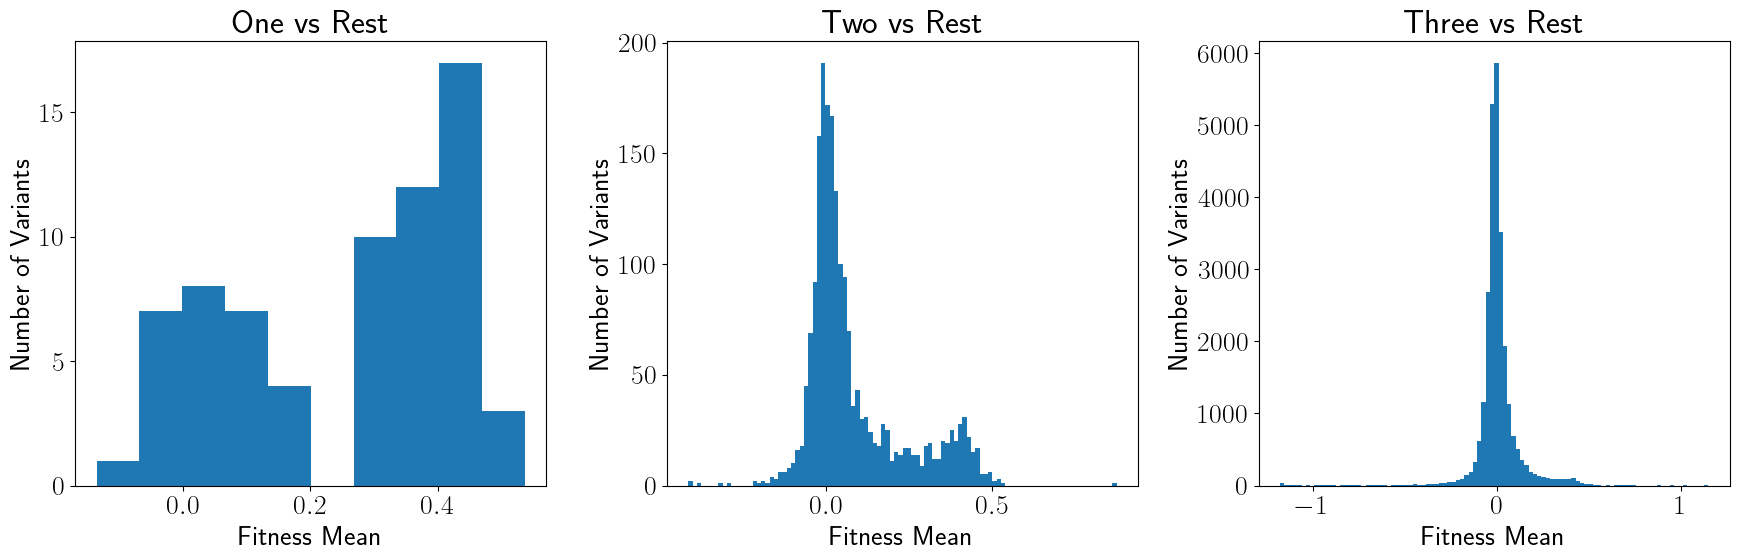

In [10]:
fig, ax = plt.subplots(figsize=(18, 6), ncols=3)
ax[0].hist(one_vs_rest_train['Fitness Mean'].values)
ax[0].set_xlabel('Fitness Mean')
ax[0].set_ylabel('Number of Variants')
ax[0].set_title('One vs Rest')

ax[1].hist(two_vs_rest_train['Fitness Mean'].values, bins=100)
ax[1].set_xlabel('Fitness Mean')
ax[1].set_ylabel('Number of Variants')
ax[1].set_title('Two vs Rest')

ax[2].hist(three_vs_rest_train['Fitness Mean'].values, bins=100)
ax[2].set_xlabel('Fitness Mean')
ax[2].set_ylabel('Number of Variants')
ax[2].set_title('Three vs Rest')

fig.tight_layout()

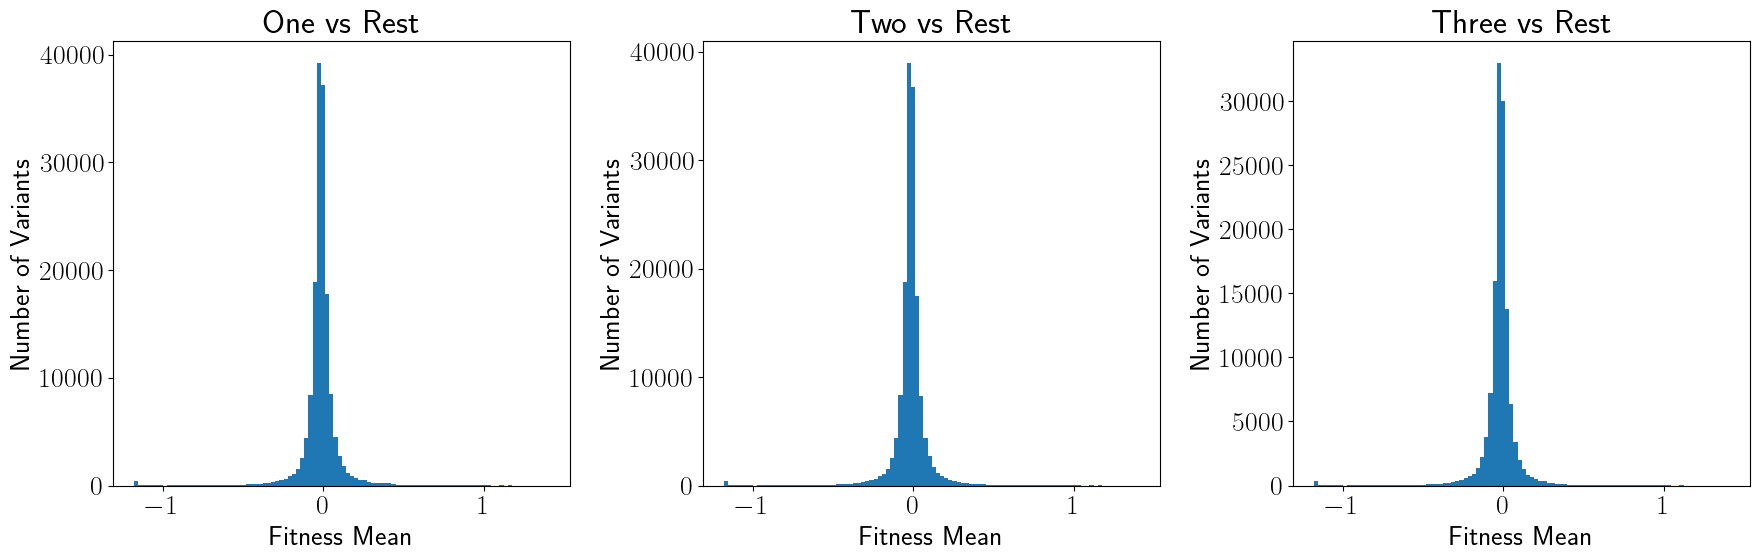

In [11]:
fig, ax = plt.subplots(figsize=(18, 6), ncols=3)
ax[0].hist(one_vs_rest_test['Fitness Mean'].values, bins=100)
ax[0].set_xlabel('Fitness Mean')
ax[0].set_ylabel('Number of Variants')
ax[0].set_title('One vs Rest')

ax[1].hist(two_vs_rest_test['Fitness Mean'].values, bins=100)
ax[1].set_xlabel('Fitness Mean')
ax[1].set_ylabel('Number of Variants')
ax[1].set_title('Two vs Rest')

ax[2].hist(three_vs_rest_test['Fitness Mean'].values, bins=100)
ax[2].set_xlabel('Fitness Mean')
ax[2].set_ylabel('Number of Variants')
ax[2].set_title('Three vs Rest')

fig.tight_layout()

In [12]:
read_count = pd.read_csv(os.path.join(data_folder, 'lib_var_count_no_lyso.csv'), sep='\t', header=None, names=['Sequences', '2', '3', '4', '5', 'Original Read Count'], index_col=False)
read_count = read_count.drop(['2', '3', '4', '5'], axis=1)
data_df_read_count = data_df.set_index('Sequences').join(read_count.set_index('Sequences'))

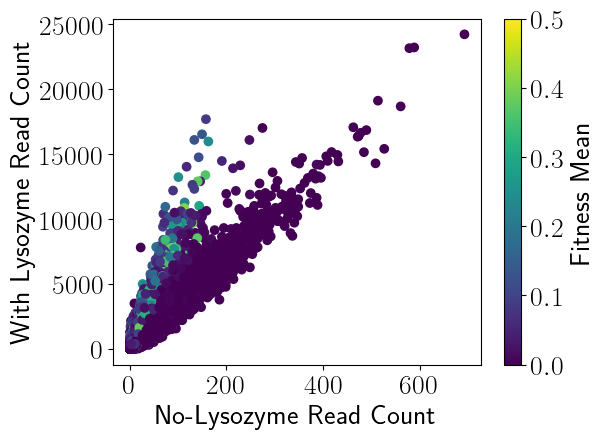

In [13]:
fig, ax = plt.subplots()
sc = ax.scatter(data_df_read_count['Original Read Count'].values, data_df_read_count['Number of Reads'].values, c=data_df_read_count['Fitness Mean'], norm=mpl.colors.Normalize(0, 0.5))
fig.colorbar(sc, label='Fitness Mean', ax=ax)
ax.set_xlabel('No-Lysozyme Read Count')
ax.set_ylabel('With Lysozyme Read Count')
fig.tight_layout()

In [ ]:
data_df_read_count.to_csv(os.path.join(data_folder, 'fitnesses_read_count.csv'))

In [ ]:
data_df_read_count = data_df_read_count.dropna(axis=0)
three_vs_rest_trainval = data_df_read_count[data_df_read_count['Mutation Distance'] <= 3]
three_vs_rest_test = data_df_read_count[data_df_read_count['Mutation Distance'] > 3]
three_vs_rest_val = three_vs_rest_trainval.sample(frac=0.1)
three_vs_rest_train = three_vs_rest_trainval.drop(three_vs_rest_val.index.values, axis=0)

three_vs_rest_train.to_csv(os.path.join(data_folder, 'Splits', 'three_vs_rest_control_train.csv'))
three_vs_rest_val.to_csv(os.path.join(data_folder, 'Splits', 'three_vs_rest_control_val.csv'))
three_vs_rest_test.to_csv(os.path.join(data_folder, 'Splits', 'three_vs_rest_control_test.csv'))

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import os
import itertools
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams.update({'font.size': 20, 'text.usetex': True})
import seaborn as sns
import pickle
import torch
from tqdm import tqdm
from Bio import SeqIO
from Levenshtein import distance

In [2]:
model_folder = '../Data/TEV_Models'

grid_space = {
    "model_embedding": [
        "linear-one_hot",
        "cnn-one_hot",
        "fnn-tape",
        "fnn-esm1b",
        "fnn-esm1v",
        "fnn-esm2_8m",
        "fnn-esm2_35m",
        "fnn-esm2_150m",
        "fnn-esm2_650m",
        "fnn-esm2",
        "fnn-prottrans",
        "fnn-carp_600k",
        "fnn-carp_38M",
        "fnn-carp_76M",
        "fnn-carp",
        "cnn-tape_all",
        "cnn-esm1b_all",
        "cnn-esm1v_all",
        "cnn-esm2_8m_all",
        "cnn-esm2_35m_all",
        "cnn-esm2_150m_all",
        "cnn-esm2_650m_all",
        "cnn-esm2_all",
        "cnn-prottrans_all",
        "cnn-carp_600k_all",
        "cnn-carp_38M_all",
        "cnn-carp_76M_all",
        "cnn-carp_all",
        "linear-augmented_esm1v",
        "linear-augmented_esm2_8m",
        "linear-augmented_esm2_35m",
        "linear-augmented_esm2_150m",
        "linear-augmented_esm2_650m",
        "linear-augmented_esm2",
        "linear-augmented_carp_600k",
        "linear-augmented_carp_38M",
        "linear-augmented_carp_76M",
        "linear-augmented_carp",
        "linear-augmented_evcoupling",
        "esmfnn-esm2_8m_finetune",
        "esmfnn-esm2_35m_finetune",
        "esmcnn-esm2_8m_finetune",
        "esmcnn-esm2_35m_finetune",
    ],
    "split": ["one_vs_rest", "two_vs_rest", "three_vs_rest"],
    "iteration": [0, 1, 2]
}

def grid_space_iter(grid):
    iter_values = list(itertools.product(*grid.values()))
    combos = [dict(zip(grid.keys(), v)) for v in iter_values]
    output = []
    for combo in combos:
        combo["model"] = combo["model_embedding"].split("-")[0]
        combo["embedding"] = combo["model_embedding"].split("-")[1]
        output.append(combo)
        combo["num_gpus"] = 1
        if combo["embedding"] == "esm2":
            combo["num_gpus"] = 2
    return output

grid_space = grid_space_iter(grid_space)

def output_str(model_combo):
    return f"{model_combo['model_embedding']}_{model_combo['split']}_iter{model_combo['iteration']}"

In [3]:
models = []
embeddings = []
model_embeddings = []
model_embedding_labels = []
model_types = []
splits = []
iterations = []
y_preds = []
y_trues = []
y_vars = []
weighted_mses = []
test_losses = []
num_params = []
model_embedding_labels_dict = {
    'linear-one_hot': 'Linear', 
    'cnn-one_hot': 'CNN', 
    'fnn-tape': 'TAPE', 
    'fnn-esm1b': 'ESM-1b', 
    'fnn-esm1v': 'ESM-1v', 
    'fnn-esm2_8m': 'ESM-2 (8M)', 
    'fnn-esm2_35m': 'ESM-2 (35M)', 
    'fnn-esm2_150m': 'ESM-2 (150M)', 
    'fnn-esm2_650m': 'ESM-2 (650M)', 
    'fnn-esm2': 'ESM-2', 
    'fnn-prottrans': 'ProtT5',
    'fnn-carp_600k': 'CARP (600k)',
    'fnn-carp_38M': 'CARP (38M)',
    'fnn-carp_76M': 'CARP (76M)',
    'fnn-carp': 'CARP', 
    'cnn-tape_all': 'TAPE (CNN)', 
    'cnn-esm1b_all': 'ESM-1b (CNN)', 
    'cnn-esm1v_all': 'ESM-1v (CNN)', 
    'cnn-esm2_8m_all': 'ESM-2 (8M, CNN)',
    'cnn-esm2_35m_all': 'ESM-2 (35M, CNN)',
    'cnn-esm2_150m_all': 'ESM-2 (150M, CNN)',
    'cnn-esm2_650m_all': 'ESM-2 (650M, CNN)',
    'cnn-esm2_all': 'ESM-2 (CNN)', 
    'cnn-prottrans_all': 'ProtT5 (CNN)', 
    'cnn-carp_600k_all': 'CARP (600k, CNN)',
    'cnn-carp_38M_all': 'CARP (38M, CNN)',
    'cnn-carp_76M_all': 'CARP (76M, CNN)',
    'cnn-carp_all': 'CARP (CNN)', 
    'linear-augmented_esm1v': 'ESM-1v (Augmented)', 
    'linear-augmented_esm2_8m': 'ESM-2 (8M, Augmented)',
    'linear-augmented_esm2_35m': 'ESM-2 (35M, Augmented)',
    'linear-augmented_esm2_150m': 'ESM-2 (150M, Augmented)',
    'linear-augmented_esm2_650m': 'ESM-2 (650M, Augmented)',
    'linear-augmented_esm2': 'ESM-2 (Augmented)', 
    'linear-augmented_carp_600k': 'CARP (600k, Augmented)',
    'linear-augmented_carp_38M': 'CARP (38M, Augmented)',
    'linear-augmented_carp_76M': 'CARP (76M, Augmented)',
    'linear-augmented_carp': 'CARP (Augmented)', 
    'linear-augmented_evcoupling': 'EVMutation (Augmented)',
    "esmfnn-esm2_8m_finetune": 'ESM-2 (8M, Finetuned)',
    "esmfnn-esm2_35m_finetune": 'ESM-2 (35M, Finetuned)',
    "esmcnn-esm2_8m_finetune": 'ESM-2 (8M, CNN, Finetuned)',
    "esmcnn-esm2_35m_finetune": 'ESM-2 (35M, CNN, Finetuned)',
}
model_type_dict = {
    'linear-one_hot': 'Baseline', 
    'cnn-one_hot': 'CNN', 
    'fnn-tape': 'FNN', 
    'fnn-esm1b': 'FNN', 
    'fnn-esm1v': 'FNN',
    'fnn-esm2_8m': 'FNN',
    'fnn-esm2_35m': 'FNN',
    'fnn-esm2_150m': 'FNN',
    'fnn-esm2_650m': 'FNN',
    'fnn-esm2': 'FNN', 
    'fnn-prottrans': 'FNN', 
    'fnn-carp_600k': 'FNN',
    'fnn-carp_38M': 'FNN',
    'fnn-carp_76M': 'FNN',
    'fnn-carp': 'FNN', 
    'cnn-tape_all': 'CNN', 
    'cnn-esm1b_all': 'CNN', 
    'cnn-esm1v_all': 'CNN',
    'cnn-esm2_8m_all': 'CNN',
    'cnn-esm2_35m_all': 'CNN',
    'cnn-esm2_150m_all': 'CNN',
    'cnn-esm2_650m_all': 'CNN',
    'cnn-esm2_all': 'CNN', 
    'cnn-prottrans_all': 'CNN',
    'cnn-carp_600k_all': 'CNN',
    'cnn-carp_38M_all': 'CNN',
    'cnn-carp_76M_all': 'CNN',
    'cnn-carp_all': 'CNN', 
    'linear-augmented_esm1v': 'Augmented',
    'linear-augmented_esm2_8m': 'Augmented',
    'linear-augmented_esm2_35m': 'Augmented',
    'linear-augmented_esm2_150m': 'Augmented',
    'linear-augmented_esm2_650m': 'Augmented',
    'linear-augmented_esm2': 'Augmented', 
    'linear-augmented_carp_600k': 'Augmented',
    'linear-augmented_carp_38M': 'Augmented',
    'linear-augmented_carp_76M': 'Augmented',
    'linear-augmented_carp': 'Augmented', 
    'linear-augmented_evcoupling': 'Augmented',
    "esmfnn-esm2_8m_finetune": 'Finetuned FNN',
    "esmfnn-esm2_35m_finetune": 'Finetuned FNN',
    "esmcnn-esm2_8m_finetune": 'Finetuned CNN',
    "esmcnn-esm2_35m_finetune": 'Finetuned CNN',
}
num_params_dict = {
    'linear-one_hot': 800,
    'cnn-one_hot': 800, 
    'fnn-tape': 9.1e7, 
    'fnn-esm1b': 6.5e8, 
    'fnn-esm1v': 6.5e8, 
    'fnn-esm2_8m': 8e6, 
    'fnn-esm2_35m': 3.5e7, 
    'fnn-esm2_150m': 1.5e8, 
    'fnn-esm2_650m': 6.5e8, 
    'fnn-esm2': 3e9, 
    'fnn-prottrans': 3e9,
    'fnn-carp_600k': 6e5,
    'fnn-carp_38M': 3.8e7,
    'fnn-carp_76M': 7.6e7,
    'fnn-carp': 6.4e8, 
    'cnn-tape_all': 9.1e7, 
    'cnn-esm1b_all': 6.5e8, 
    'cnn-esm1v_all': 6.5e8, 
    'cnn-esm2_8m_all': 8e6,
    'cnn-esm2_35m_all': 3.5e7,
    'cnn-esm2_150m_all': 1.5e8,
    'cnn-esm2_650m_all': 6.5e8,
    'cnn-esm2_all': 3e9, 
    'cnn-prottrans_all': 3e9, 
    'cnn-carp_600k_all': 6e5,
    'cnn-carp_38M_all': 3.8e7,
    'cnn-carp_76M_all': 7.6e7,
    'cnn-carp_all': 6.4e8, 
    'linear-augmented_esm1v': 6.5e8, 
    'linear-augmented_esm2_8m': 8e6,
    'linear-augmented_esm2_35m': 3.5e7,
    'linear-augmented_esm2_150m': 1.5e8,
    'linear-augmented_esm2_650m': 6.5e8,
    'linear-augmented_esm2': 3e9, 
    'linear-augmented_carp_600k': 6e5,
    'linear-augmented_carp_38M': 3.8e7,
    'linear-augmented_carp_76M': 7.6e7,
    'linear-augmented_carp': 6.4e8, 
    'linear-augmented_evcoupling': 800,
    "esmfnn-esm2_8m_finetune": 8e6,
    "esmfnn-esm2_35m_finetune": 3.5e7,
    "esmcnn-esm2_8m_finetune": 8e6,
    "esmcnn-esm2_35m_finetune": 3.5e7,
}
split_labels_dict = {'one_vs_rest': 'One vs Rest', 'two_vs_rest': 'Two vs Rest', 'three_vs_rest': 'Three vs Rest'}

for model_combo in tqdm(grid_space):
    models += [model_combo['model']]
    embeddings += [model_combo['embedding']]
    model_embeddings += [model_combo['model_embedding']]
    splits += [split_labels_dict[model_combo['split']]]
    iterations += [model_combo['iteration']]
    model_embedding_labels += [model_embedding_labels_dict[model_combo['model_embedding']]]
    model_types += [model_type_dict[model_combo['model_embedding']]]
    num_params += [num_params_dict[model_combo['model_embedding']]]

    output_dir = os.path.join(model_folder, output_str(model_combo))
    test_pred = np.load(os.path.join(output_dir, 'test_preds.npy'))
    test_true = np.load(os.path.join(output_dir, 'test_trues.npy'))
    test_var = np.load(os.path.join(output_dir, 'test_vars.npy'))
    test_sequences = np.load(os.path.join(output_dir, 'test_sequences.npy'))
    y_preds += [test_pred]
    y_trues += [test_true]
    y_vars += [test_var]
    test_losses += [np.load(os.path.join(output_dir, 'test_loss.npy'))[0]]
    weighted_mses += [np.mean((test_true - test_pred)**2 * 1/(test_var))]

100%|██████████████████████████████████████████████████████████████████| 387/387 [02:56<00:00,  2.20it/s]


In [19]:
data_folder = '../Data/TEV_Landscape'
with open(os.path.join(data_folder, "TEV_wt_sequence.fasta")) as f:
    wt_record = SeqIO.read(f, format="fasta")
    
controlled_weighted_mses = []
for y_pred_sample, y_true_sample, y_var_sample, model_combo in tqdm(zip(y_preds, y_trues, y_vars, grid_space)):
    output_dir = os.path.join(model_folder, output_str(model_combo))
    test_sequences = np.load(os.path.join(output_dir, 'test_sequences.npy'))
    mask = [distance(str(wt_record.seq), seq) == 4 for seq in test_sequences]
    y_pred_sample = y_pred_sample[mask]
    y_true_sample = y_true_sample[mask]
    y_var_sample = y_var_sample[mask]
    controlled_weighted_mses += [np.mean((y_true_sample - y_pred_sample)**2 * 1/(y_var_sample))]

387it [13:21,  2.07s/it]


In [4]:
results_df = {'Model': model_embedding_labels, 'Model Type': model_types, 'Task': splits, 'Iteration': iterations, 'Weighted MSE': weighted_mses, 'Controlled Weighted MSE': controlled_weighted_mses, 'Test Loss': test_losses, 'Number of Parameters': num_params}
results_df = pd.DataFrame(results_df)

In [5]:
def p_value_min(s, props=''):
    means = s.apply(lambda x: float(x.split('±')[0])).values
    stds = s.apply(lambda x: float(x.split('±')[1])).values
    pvalues = [stats.ttest_ind_from_stats(mean, std, 3, np.min(means), stds[np.argmin(means)], 3, equal_var=False).pvalue for (mean, std) in zip(means, stds)]
    return np.where(np.array(pvalues) > 0.05, props, '')

def highlight_min(s, props=''):
    means = s.apply(lambda x: float(x.split('±')[0])).values
    return np.where(means == np.min(means), props, '')


row_order = ['Linear', 'TAPE', 'ESM-1b', 'ESM-1v', 'ESM-2 (8M)', 'ESM-2 (35M)', 'ESM-2 (150M)', 'ESM-2 (650M)', 'ESM-2', 'ProtT5', 'CARP (600k)', 'CARP (38M)', 'CARP (76M)', 'CARP', 'CNN', 'TAPE (CNN)', 'ESM-1b (CNN)', 'ESM-1v (CNN)', 'ESM-2 (8M, CNN)', 'ESM-2 (35M, CNN)', 'ESM-2 (150M, CNN)', 'ESM-2 (650M, CNN)', 'ESM-2 (CNN)', 'ProtT5 (CNN)', 'CARP (600k, CNN)', 'CARP (38M, CNN)', 'CARP (76M, CNN)', 'CARP (CNN)', 'ESM-1v (Augmented)', 'ESM-2 (8M, Augmented)', 'ESM-2 (35M, Augmented)', 'ESM-2 (150M, Augmented)', 'ESM-2 (650M, Augmented)', 'ESM-2 (Augmented)', 'CARP (600k, Augmented)', 'CARP (38M, Augmented)', 'CARP (76M, Augmented)', 'CARP (Augmented)', 'EVMutation (Augmented)', 'ESM-2 (8M, Finetuned)', 'ESM-2 (35M, Finetuned)', 'ESM-2 (8M, CNN, Finetuned)', 'ESM-2 (35M, CNN, Finetuned)']
column_order = ['One vs Rest', 'Two vs Rest', 'Three vs Rest']
results_df_mean_std = results_df.groupby(['Model', 'Task']).agg(['mean', 'std'])['Weighted MSE']
results_df_mean_std_grouped = results_df_mean_std.apply(lambda x: f"{x['mean']:.4f} ± {x['std']:.4f}", axis=1)
results_df_combined = results_df_mean_std_grouped.to_frame(name='Weighted MSE').reset_index().pivot(values='Weighted MSE', index='Model', columns='Task').reindex(row_order)[column_order]
results_df_combined_styled = results_df_combined.style.apply(p_value_min, props='background-color:yellow', axis=0).apply(highlight_min, props='font-weight:bold', axis=0)
results_df_combined_styled

/tmp/ipykernel_967299/25127647.py:14: FutureWarning: ['Model Type'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  results_df_mean_std = results_df.groupby(['Model', 'Task']).agg(['mean', 'std'])['Weighted MSE']


Task,One vs Rest,Two vs Rest,Three vs Rest
Model,,,
Linear,526.0933 ± 22.7232,473.0123 ± 30.1776,61.9535 ± 9.9049
TAPE,297.5274 ± 16.9196,42.1769 ± 5.7037,10.1017 ± 2.9131
ESM-1b,165.9262 ± 0.8583,19.2814 ± 2.1384,4.7189 ± 0.0789
ESM-1v,96.5753 ± 4.8990,31.6219 ± 8.8151,5.0249 ± 0.2268
ESM-2 (8M),487.1830 ± 67.0827,77.3104 ± 13.6258,26.0598 ± 11.2005
ESM-2 (35M),201.0534 ± 14.7650,38.3270 ± 14.7239,5.3898 ± 0.0861
ESM-2 (150M),253.0745 ± 17.7263,21.2191 ± 4.1567,5.8834 ± 0.7763
ESM-2 (650M),129.0170 ± 3.0636,15.7421 ± 2.0325,5.0022 ± 0.5990
ESM-2,455.1378 ± 8.2257,21.5850 ± 7.1289,16.4862 ± 17.6678


In [ ]:
for model_embedding_label, y_pred_sample, y_true_sample, y_var_sample, split, model_combo in tqdm(zip(model_embedding_labels, y_preds, y_trues, y_vars, splits, grid_space)):
    fig, ax = plt.subplots(ncols=2, figsize=(16, 6))
    cmap = ax[0].scatter(y_pred_sample, y_true_sample, c=np.sqrt(y_var_sample))
    fig.colorbar(cmap, ax=ax[0], label='Error')
    ax[0].set_xlabel('Predicted Fitness')
    ax[0].set_ylabel('True Fitness')

    cutoff = 0.05
    cmap = ax[1].scatter(y_pred_sample[np.sqrt(y_var_sample) < cutoff], y_true_sample[np.sqrt(y_var_sample) < cutoff], c=np.sqrt(y_var_sample)[np.sqrt(y_var_sample) < cutoff])
    fig.colorbar(cmap, ax=ax[1], label='Error')
    ax[1].set_xlabel('Predicted Fitness')
    ax[1].set_ylabel('True Fitness')

    fig.suptitle(model_embedding_label + " " + split)
    fig.tight_layout()

    output_dir = os.path.join(model_folder, output_str(model_combo))
    fig.savefig(os.path.join(output_dir, 'test_results.png'))
    plt.close()

/tmp/ipykernel_967299/4283850694.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(tasks)


[]

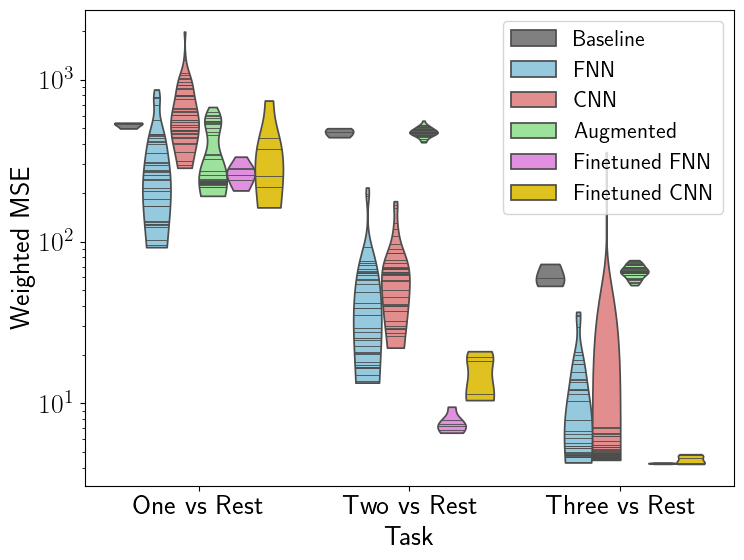

In [6]:
tasks = ['One vs Rest', 'Two vs Rest', 'Three vs Rest']
fig, ax = plt.subplots(figsize=(8, 6))
sns.violinplot(results_df, x='Task', y='Weighted MSE', hue='Model Type', density_norm='width', hue_order=['Baseline', 'FNN', 'CNN', 'Augmented', 'Finetuned FNN', 'Finetuned CNN'], palette=['grey', 'skyblue', 'lightcoral', 'lightgreen', 'violet', 'gold'], cut=0, inner="stick")
ax.set_xticklabels(tasks)
fig.tight_layout()
ax.legend(fontsize=16)
ax.semilogy()

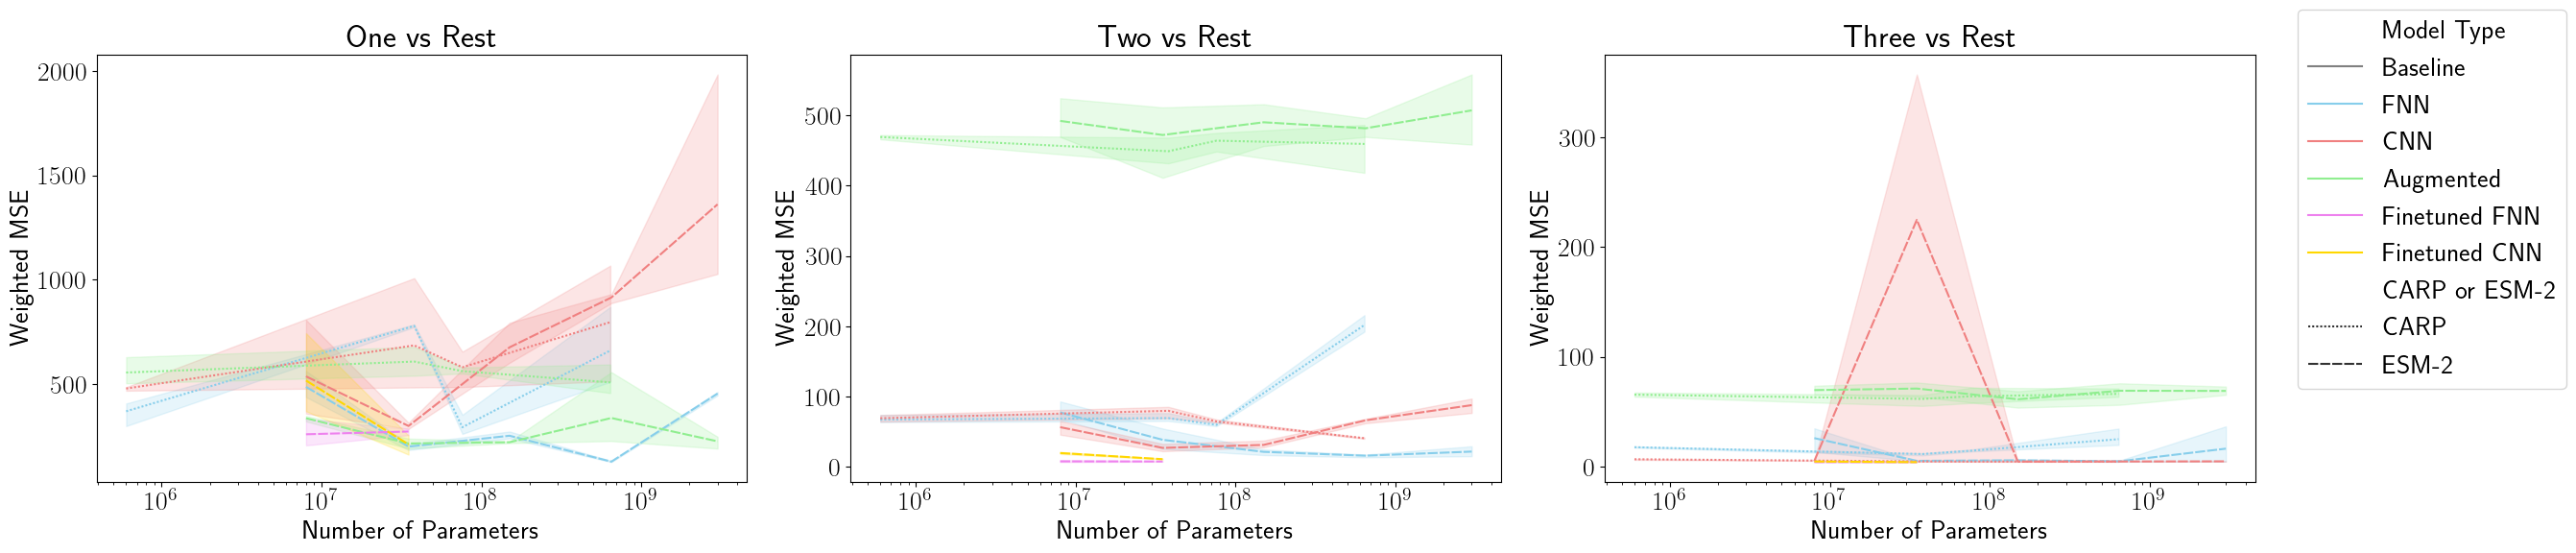

In [23]:
pd.options.mode.chained_assignment = None
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(24, 6))
for i, task in enumerate(tasks):
    results_df_sub = results_df[results_df['Task'] == task]
    carp_results_df = results_df_sub[[val.startswith('CARP') for val in results_df_sub['Model'].values]]
    carp_results_df['CARP or ESM-2'] = 'CARP'
    esm2_results_df = results_df_sub[[val.startswith('ESM-2') for val in results_df_sub['Model'].values]]
    esm2_results_df['CARP or ESM-2'] = 'ESM-2'
    results_df_sub = pd.concat([carp_results_df, esm2_results_df])
    sns.lineplot(results_df_sub, x='Number of Parameters', y='Weighted MSE', ax=ax[i], style='CARP or ESM-2', hue='Model Type', hue_order=['Baseline', 'FNN', 'CNN', 'Augmented', 'Finetuned FNN', 'Finetuned CNN'], palette=['grey', 'skyblue', 'lightcoral', 'lightgreen', 'violet', 'gold'], dashes = [(1, 1), (5, 1)])
    ax[i].semilogx()
    ax[i].legend().set_visible(False)
    ax[i].set_title(task)
handles, labels = ax[0].get_legend_handles_labels()
lgd = fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(1, 1))
fig.tight_layout()

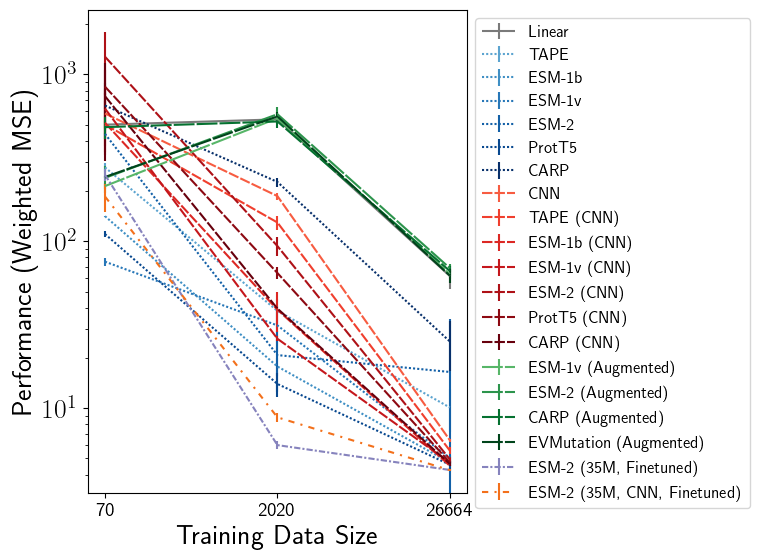

In [24]:
models = ['Linear', 'TAPE', 'ESM-1b', 'ESM-1v', 'ESM-2', 'ProtT5', 'CARP', 'CNN', 'TAPE (CNN)', 'ESM-1b (CNN)', 'ESM-1v (CNN)', 'ESM-2 (CNN)', 'ProtT5 (CNN)', 'CARP (CNN)', 'ESM-1v (Augmented)', 'ESM-2 (Augmented)', 'CARP (Augmented)', 'EVMutation (Augmented)', 'ESM-2 (35M, Finetuned)', 'ESM-2 (35M, CNN, Finetuned)']
results_df_sub = results_df[[model in models for model in results_df['Model']]]
results_df_mean_std_sub = results_df_sub.groupby(['Model', 'Task']).agg(['mean', 'std'])['Controlled Weighted MSE']
results_df_mean_sub = results_df_mean_std_sub['mean'].to_frame(name='Controlled Weighted MSE').reset_index().pivot(values='Controlled Weighted MSE', index='Model', columns='Task')
results_df_std_sub = results_df_mean_std_sub['std'].to_frame(name='Controlled Weighted MSE').reset_index().pivot(values='Controlled Weighted MSE', index='Model', columns='Task')

classifications = np.array([0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 5])
styles = {0: (0, ()), 1: (0, (1, 1)), 2: (0, (5, 1)), 3: (0, (10, 1)), 4: (0, (3, 1, 1, 1)), 5: (0, (3, 3, 1, 3))}
lengths = [len(classifications[classifications == i]) for i in range(6)]
colormap_names = ['Greys', 'Blues', 'Reds', 'Greens', 'Purples', 'Oranges']
colormaps = []
for colormap_name, length in zip(colormap_names, lengths):
    if length == 1:
        colormaps += [mpl.colormaps[colormap_name].resampled(6)(3)]
    else:
        colormaps += [mpl.colormaps[colormap_name].resampled(2*length)(range(length, 2*length))]
colormaps = np.vstack(colormaps)

fig, ax = plt.subplots(figsize=(8, 6))
for model, classification, color in zip(models, classifications, colormaps):
    ax.errorbar([0, 1, 2], results_df_mean_sub.loc[model][['One vs Rest', 'Two vs Rest', 'Three vs Rest']].values, yerr=results_df_std_sub.loc[model][['One vs Rest', 'Two vs Rest', 'Three vs Rest']].values, c=color, linestyle=styles[classification], label=model)
ax.semilogy()
ax.set_ylabel('Performance (Weighted MSE)')
ax.set_xlabel('Training Data Size')
ax.set_xticks([0, 1, 2])
ax.set_xticklabels([70, 2020, 26664], fontsize=14)
ax.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))
fig.tight_layout()

In [25]:
control_run_folder = os.path.join(model_folder, 'control_run')
control_run_test_preds = np.load(os.path.join(control_run_folder, 'test_preds.npy'))
control_run_test_trues = np.load(os.path.join(control_run_folder, 'test_trues.npy'))

Text(0, 0.5, 'True Number of Reads')

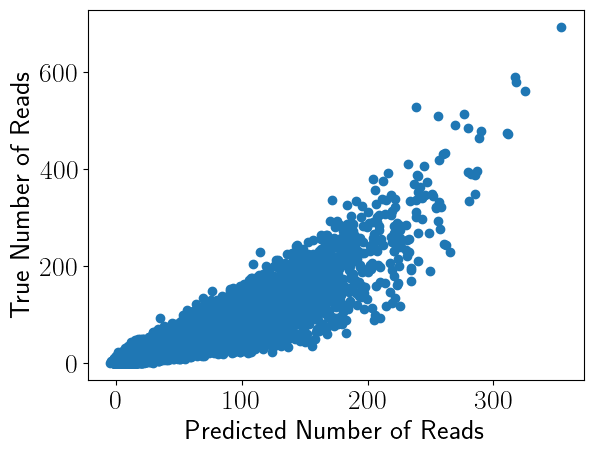

In [26]:
fig, ax = plt.subplots()
ax.scatter(control_run_test_preds, control_run_test_trues)
ax.set_xlabel('Predicted Number of Reads')
ax.set_ylabel('True Number of Reads')